In [2]:
# Cell 1 - Minimal imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,4)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


In [3]:
# Cell 2 - Load dataset (your AAPL.csv)
df = pd.read_csv("AAPL.csv", sep=None, engine="python")  # flexible sep
# Date format is dd-mm-yyyy in your sample -> parse with dayfirst=True
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Date').set_index('Date')
# Keep columns we need and rename to consistent lowercase
df = df.rename(columns=lambda c: c.strip()).copy()
print("Columns:", df.columns.tolist())
df = df[['Open','High','Low','Close','Adj Close','Volume']].ffill().bfill()
display(df.head(8))

Columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
2012-01-10,60.844284,60.857143,60.214287,60.462856,52.248333,64549100
2012-01-11,60.382858,60.407143,59.901428,60.364285,52.163139,53771200
2012-01-12,60.325714,60.414288,59.821430,60.198570,52.019955,53146800


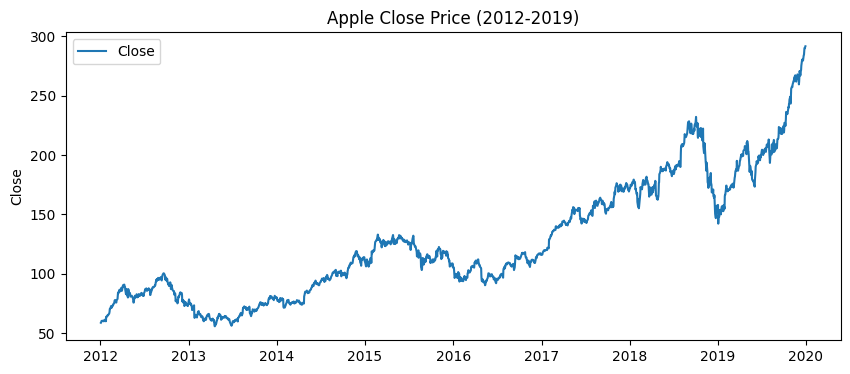

count    2011.0000
mean      126.7412
std        50.5784
min        55.7900
25%        86.2021
50%       113.0500
75%       165.2450
max       291.5200
Name: Close, dtype: float64

In [4]:
# Cell 3 - Quick EDA & trend plots
plt.plot(df.index, df['Close'], label='Close')
plt.title("Apple Close Price (2012-2019)")
plt.ylabel("Close")
plt.legend()
plt.show()

# Summary stats
display(df['Close'].describe().round(4))


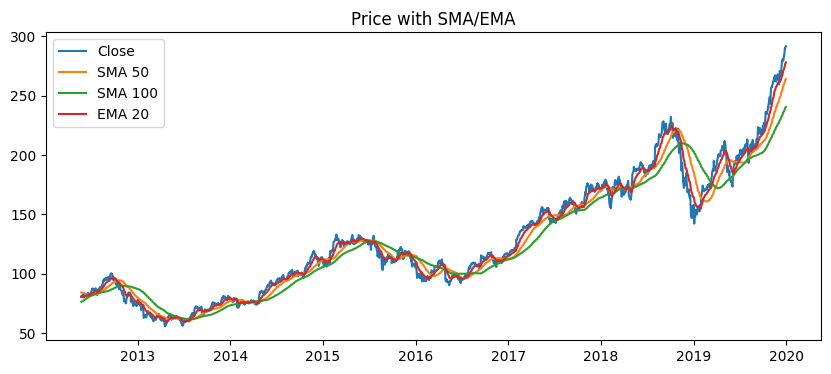

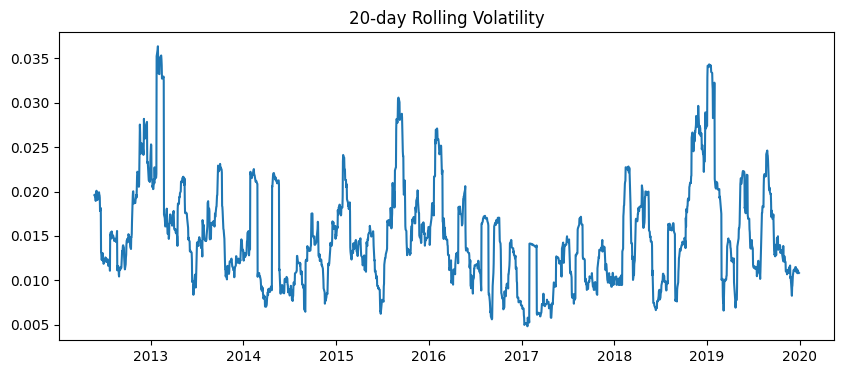

In [5]:
# Cell 4 - Feature engineering: SMA, EMA, returns, volatility
data = df.copy()
data['return'] = data['Close'].pct_change()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_100'] = data['Close'].rolling(window=100).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['vol_20'] = data['return'].rolling(window=20).std()  # 20-day rolling volatility
data = data.dropna()

# Plots
plt.plot(data.index, data['Close'], label='Close')
plt.plot(data.index, data['SMA_50'], label='SMA 50')
plt.plot(data.index, data['SMA_100'], label='SMA 100')
plt.plot(data.index, data['EMA_20'], label='EMA 20')
plt.title("Price with SMA/EMA")
plt.legend()
plt.show()

plt.plot(data.index, data['vol_20']); plt.title("20-day Rolling Volatility"); plt.show()


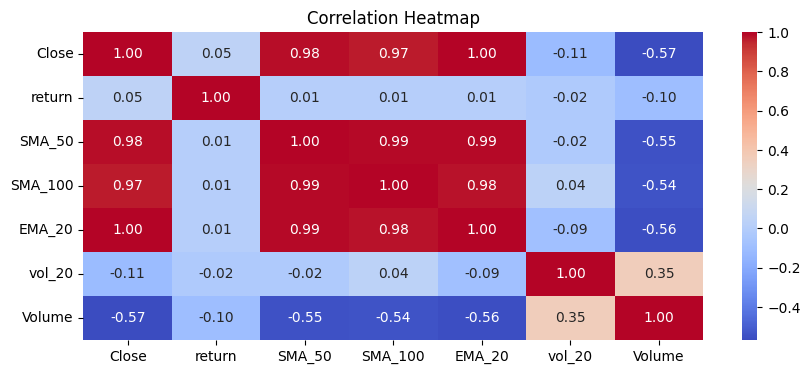

In [6]:
# Cell 5 - Correlation heatmap (selected features)
corr_cols = ['Close','return','SMA_50','SMA_100','EMA_20','vol_20','Volume']
sns.heatmap(data[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [7]:
# Cell 6 - Prepare supervised dataset with lag features for ML models
def make_lags(df, target='Close', n_lags=10):
    out = df.copy()
    for i in range(1, n_lags+1):
        out[f'lag_{i}'] = out[target].shift(i)
    out = out.dropna()
    return out

n_lags = 10
sup = make_lags(data, target='Close', n_lags=n_lags)
feature_cols = ['Open','High','Low','Volume','return','SMA_50','SMA_100','EMA_20','vol_20'] + [f'lag_{i}' for i in range(1,n_lags+1)]
sup = sup[feature_cols + ['Close']].dropna()
X = sup[feature_cols]
y = sup['Close']
print("Supervised shape:", X.shape)


Supervised shape: (1902, 19)


In [8]:
# Cell 7 - Train/test split (time-aware: last 20% test)
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])

Train / Test sizes: 1521 381


In [9]:
# Cell 8 - Scale features for ML and LSTM
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_s = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()
# Save scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")


['scaler_y.pkl']

In [10]:
# Cell 9 - Baseline metrics & helpers
from sklearn.metrics import mean_squared_error, mean_absolute_error
def eval_metrics(y_true, y_pred, tag="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae

def plot_preds(idx, actual, pred, title="Actual vs Predicted"):
    plt.plot(idx, actual, label='Actual')
    plt.plot(idx, pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()


RandomForest (unscaled target) -> RMSE: 30.5075, MAE: 19.3999


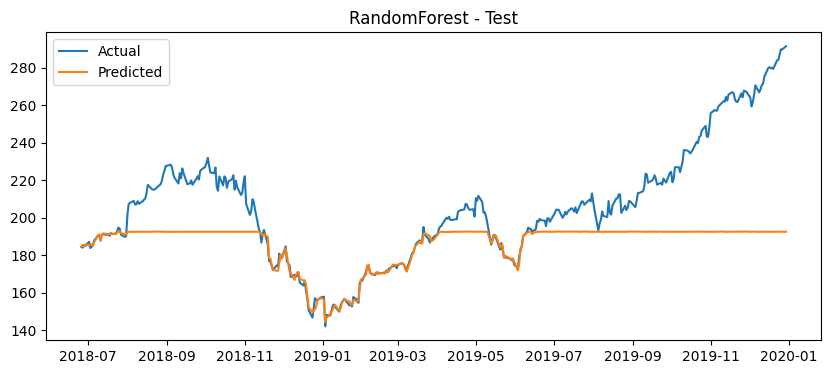

['rf_model.pkl']

In [11]:
# Cell 10 - Random Forest (light settings)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train_s, y_train)
rf_pred = rf.predict(X_test_s)
eval_metrics(y_test, rf_pred, tag="RandomForest (unscaled target)")
plot_preds(y_test.index, y_test.values, rf_pred, title="RandomForest - Test")
# Save model
joblib.dump(rf, "rf_model.pkl")


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA -> RMSE: 38.5118, MAE: 29.9575


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


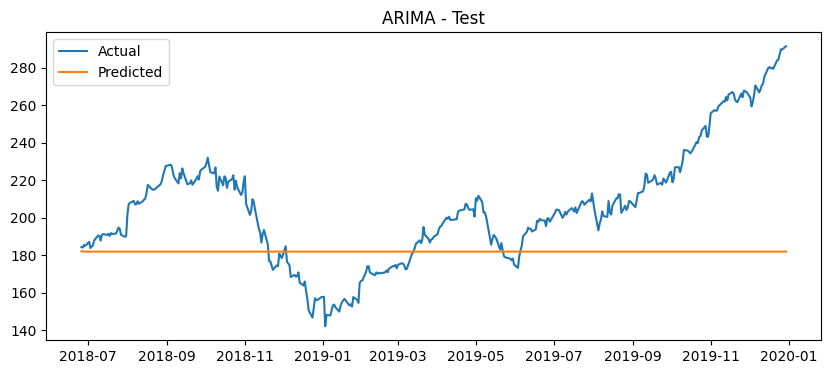

['arima_model.pkl']

In [12]:
# Cell 11 - ARIMA (use a small order to keep it fast)
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA on full Close training series (use y_train index aligned)
close_train_series = y_train  # y_train is Close values indexed by date
arima_order = (5,1,0)  # reasonable small order
arima_model = ARIMA(close_train_series, order=arima_order).fit()
arima_forecast_test = arima_model.forecast(steps=len(y_test))
eval_metrics(y_test, arima_forecast_test, tag="ARIMA")
plot_preds(y_test.index, y_test.values, arima_forecast_test, title="ARIMA - Test")
# Save
joblib.dump(arima_model, "arima_model.pkl")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM -> RMSE: 7.0392, MAE: 5.1756


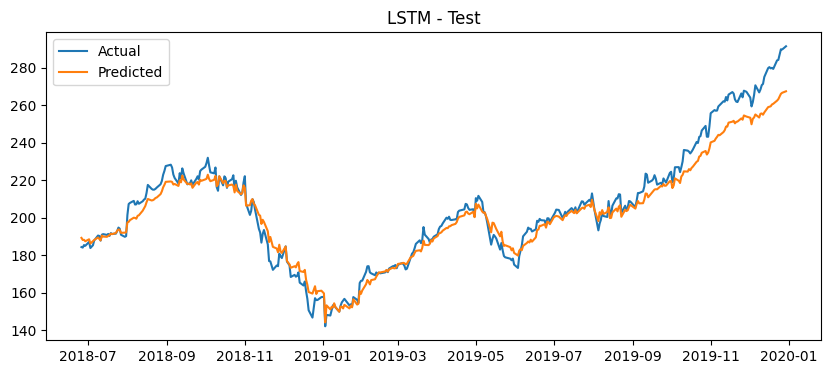

In [13]:
# Cell 12 - LSTM prep: create sequences using scaled X and scaled y
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
tf.random.set_seed(RANDOM_SEED)

# We'll use only lag features + a few engineered features for LSTM to keep input size reasonable
lstm_features = feature_cols  # same order we used
# Prepare sequences: each sample is X_train_s row (already contains lags)
# LSTM expects 3D: (samples, timesteps, features). We'll treat timesteps=1 (fast approach),
# or alternatively reshape last n_lags as timesteps — to keep simple we use timesteps=1 and features=len(cols)
X_train_lstm = X_train_s.reshape((X_train_s.shape[0], 1, X_train_s.shape[1]))
X_test_lstm = X_test_s.reshape((X_test_s.shape[0], 1, X_test_s.shape[1]))
y_train_lstm = y_train_s
y_test_lstm = y_test_s

# Build a tiny LSTM
model_lstm = Sequential([
    LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
# Train with small epochs so it runs quickly
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=12, batch_size=32, validation_split=0.1, verbose=0)
# Predict and inverse transform
lstm_pred_s = model_lstm.predict(X_test_lstm).ravel()
lstm_pred = scaler_y.inverse_transform(lstm_pred_s.reshape(-1,1)).ravel()
eval_metrics(y_test, lstm_pred, tag="LSTM")
plot_preds(y_test.index, y_test.values, lstm_pred, title="LSTM - Test")
# Save Keras model
model_lstm.save("lstm_model.h5")


In [14]:
# Cell 13 - Utilities to create next-day feature row (simple recursive for 30 days)
from pandas.tseries.offsets import BDay

def recursive_forecast_ml(model, last_supervised_row, scaler_X, scaler_y, feature_cols, n_days=30):
    """
    model: trained sklearn model (predicts in original target scale)
    last_supervised_row: pandas Series containing the last feature row (values aligned to feature_cols)
    """
    curr = last_supervised_row.copy()
    preds = []
    dates = []
    last_date = last_supervised_row.name  # index date
    for i in range(n_days):
        x = curr.values.reshape(1,-1)
        x_s = scaler_X.transform(x)
        p = model.predict(x_s)[0]
        # shift lag features in curr (lag_10 <- lag_9 ... lag_1 <- p)
        for lag in range(n_lags,1,-1):
            curr[f'lag_{lag}'] = curr[f'lag_{lag-1}']
        curr['lag_1'] = p
        # do not recompute SMA/EMA/vol for simplicity (mention in README)
        last_date = last_date + BDay(1)
        preds.append(p)
        dates.append(last_date)
    return pd.Series(preds, index=dates, name='Predicted_Close')

# prepare last row
last_row = sup.iloc[-1][feature_cols].copy()
rf_30 = recursive_forecast_ml(rf, last_row, scaler_X, scaler_y, feature_cols, n_days=30)
rf_30.to_csv("rf_30_day_forecast.csv")
print("RF 30-day forecast saved.")


RF 30-day forecast saved.


In [15]:
# Cell 14 - ARIMA 30-day forecast (univariate, uses full Close series)
from pandas.tseries.offsets import BDay
full_close = data['Close']
arima_full = ARIMA(full_close, order=arima_order).fit()
arima_30 = arima_full.forecast(steps=30)
# create business-day index starting next BDay after last date
last_date = full_close.index[-1]
future_dates = pd.bdate_range(start=last_date + BDay(1), periods=30)
arima_30_series = pd.Series(arima_30, index=future_dates, name='ARIMA_30')
arima_30_series.to_csv("arima_30_day_forecast.csv")
print("ARIMA 30-day forecast saved.")


ARIMA 30-day forecast saved.


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an

In [16]:
# Cell 15 - LSTM 30-day recursive forecast (use scaled pipeline, a bit simpler)
def recursive_forecast_lstm(keras_model, last_supervised_row, scaler_X, scaler_y, n_days=30):
    curr = last_supervised_row.copy()
    preds = []
    dates = []
    last_date = last_supervised_row.name
    for i in range(n_days):
        x = curr.values.reshape(1,-1)
        x_s = scaler_X.transform(x).reshape(1,1,-1)
        p_s = keras_model.predict(x_s)[0,0]
        p = scaler_y.inverse_transform(np.array([[p_s]]))[0,0]
        # shift lag features
        for lag in range(n_lags,1,-1):
            curr[f'lag_{lag}'] = curr[f'lag_{lag-1}']
        curr['lag_1'] = p
        last_date = last_date + BDay(1)
        preds.append(p)
        dates.append(last_date)
    return pd.Series(preds, index=dates, name='LSTM_30')

lstm_30 = recursive_forecast_lstm(model_lstm, last_row, scaler_X, scaler_y, n_days=30)
lstm_30.to_csv("lstm_30_day_forecast.csv")
print("LSTM 30-day forecast saved.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

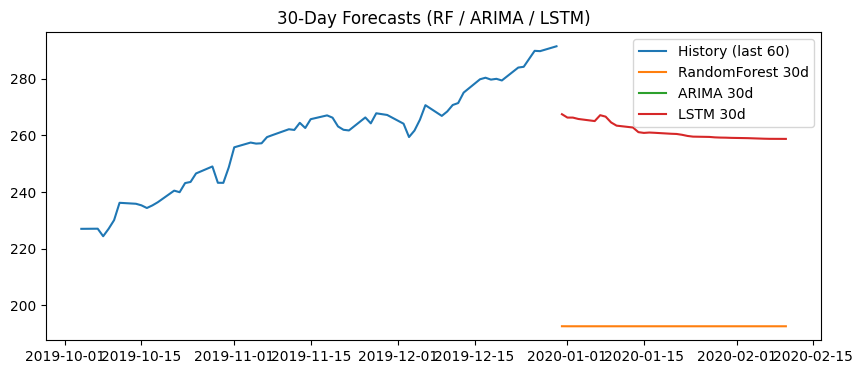

In [17]:
# Cell 16 - Plot all 30-day forecasts together with last 60 days history
last_60 = data['Close'].iloc[-60:]
plt.plot(last_60.index, last_60.values, label='History (last 60)')
plt.plot(rf_30.index, rf_30.values, label='RandomForest 30d')
plt.plot(arima_30_series.index, arima_30_series.values, label='ARIMA 30d')
plt.plot(lstm_30.index, lstm_30.values, label='LSTM 30d')
plt.legend()
plt.title("30-Day Forecasts (RF / ARIMA / LSTM)")
plt.show()


In [18]:
# Cell 17 - Save key artifacts and a brief report CSV
joblib.dump(rf, "rf_model.pkl")
joblib.dump(arima_model, "arima_train_obj.pkl")  # small pickle of fitted model
# LSTM saved earlier
# Save a small summary
summary = {
    'model':['RandomForest','ARIMA','LSTM'],
    'notes':['RF trained on lag+engineered features','ARIMA univariate fit on Close','LSTM small network, 12 epochs']
}
pd.DataFrame(summary).to_csv("models_summary.csv", index=False)
print("Artifacts saved: rf_model.pkl, arima_train_obj.pkl, lstm_model.h5, summary CSV")

Artifacts saved: rf_model.pkl, arima_train_obj.pkl, lstm_model.h5, summary CSV
